# Italian market portfolio optimization

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from utils import *
from Dataset.datasets import *
from Dataset.aggregation import *
from Dataset.metrics import *
from Optimization.clustering import *
from Optimization.portfolio_opt import *
from Evaluation.evaluate import *
from Evaluation.Plot_results import *
warnings.filterwarnings('ignore')

### Dates for training and evaluation

In [2]:
start_date_train = '2006-06-01'
end_date_train = '2016-01-01'

start_date_validation = '2016-01-01'
end_date_validation = '2024-01-23'


## Dataset preparation

In [3]:
df = download_stock_data(market_country ='IT', start_date = '2006-01-01',)

[*********************100%%**********************]  365 of 365 completed


72 Failed downloads:
['TIS.MI', 'ELIN.MI', 'ROS.MI', 'FHR.MI', 'MOLD.MI', 'PRI.MI', 'WMC.MI', 'PAN.MI', 'ASSI.MI', 'FAR.MI', 'BDBR.MI', 'ATH.MI', 'FNL.MI', 'MS.MI', 'DEA.MI', 'TTT.MI', 'ACS.MI', 'LIT.MI', 'COV.MI', 'NET.MI', 'EC.MI', 'EVS.MI', 'REEVO.MI', 'PSF.MI', 'BEST.MI', 'ESI.MI', 'FUL.MI', 'SOU.MI', 'RM.MI', 'PSA.MI', 'BIM.MI', 'BLUE.MI', 'DIG.MI', 'ISGS.MI', 'AMM.MI', 'CRES.MI', 'AED.MI', 'CVAL.MI', 'SIO.MI', 'LD.MI', 'KIP.MI', 'PITE.MI', 'ISG.MI', 'IKG.MI', 'PLT.MI', 'SITI.MI', 'GCL.MI', 'CERV.MI', 'BOR.MI', 'ATL.MI', 'SGR.MI', 'BCM.MI', 'KI.MI', 'ASR.MI', 'VTY.MI', 'EXSY.MI', 'YIV.MI', 'EMC.MI', 'LBM.MI', 'MAIL.MI', 'SICT.MI', 'FED.MI', 'TAS.MI', 'CARR.MI', 'FKR.MI', 'AST.MI', 'AT.MI', 'BFE.MI', 'MT.MI', 'AGL.MI', 'SEB.MI']: Exception('%ticker%: No timezone found, symbol may be delisted')
['EPR.MI']: Exception('%ticker%: No data found, symbol may be delisted')


In [4]:
df.head()

adj close      close       high        low       open  \
date       ticker                                                            
2006-01-02 A2A.MI     0.696583   1.621000   1.623000   1.605000   1.605000   
           ACE.MI     3.695696   8.360000   8.420000   8.350000   8.420000   
           AMP.MI     4.782180   5.672000   5.734000   5.655000   5.700000   
           ARN.MI     3.309356   4.445000   4.495000   4.400000   4.455000   
           AUTME.MI   3.744272  36.990002  36.990002  36.990002  36.990002   

                        volume  
date       ticker               
2006-01-02 A2A.MI    1282006.0  
           ACE.MI      35926.0  
           AMP.MI      27050.0  
           ARN.MI      27939.0  
           AUTME.MI      902.0

In [5]:
stock_measures = StockMeasures(df)
stock_measures.calculate_measures('all')
stock_measures.measures

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                      
2006-01-02 A2A.MI           -0.269073        NaN       NaN       NaN   
           ACE.MI           -0.261894        NaN       NaN       NaN   
           AMP.MI           -0.011811        NaN       NaN       NaN   
           ARN.MI           -0.033909        NaN       NaN       NaN   
           AUTME.MI         -2.026510        NaN       NaN       NaN   
...                               ...        ...       ...       ...   
2024-01-25 XPR.MI            0.000000  40.336871  0.955394  0.975565   
           YRM.MI            0.000000  50.801228  3.836196  3.895557   
           YSFT.MI           0.006188  25.583282  0.459323  0.598796   
           ZUC.MI            0.000009  49.175472  1.160684  1.188508   
           ZV.MI             0.000041  54.108551  2.655127  2.694099   

                      bb_high       atr      macd  dollar_volume  
date       ticker                                                 
2006-01-02 A2A.MI         NaN       NaN       NaN       0.893024  
           ACE.MI         NaN       NaN       NaN       0.132772  
           AMP.MI         NaN       NaN       NaN       0.129358  
           ARN.MI         NaN       NaN       NaN       0.092460  
           AUTME.MI       NaN       NaN       NaN       0.003377  
...                       ...       ...       ...            ...  
2024-01-25 XPR.MI    0.995736 -0.808505 -0.808505       0.000470  
           YRM.MI    3.954918  3.971708  3.971708       0.000000  
           YSFT.MI   0.738270  0.101716  0.101716       0.006861  
           ZUC.MI    1.216333 -0.690234 -0.690234       0.003972  
           ZV.MI     2.733071  0.897110  0.897110       1.426933  

[877130 rows x 8 columns]

Now we add to the feature dataframe the columns of adjusted close and volume. 

In [6]:
data_fit = stock_measures.measures.copy()
data_fit["adj close"] = df["adj close"]
data_fit.head()

garman_klass_vol  rsi  bb_low  bb_mid  bb_high  atr  \
date       ticker                                                          
2006-01-02 A2A.MI           -0.269073  NaN     NaN     NaN      NaN  NaN   
           ACE.MI           -0.261894  NaN     NaN     NaN      NaN  NaN   
           AMP.MI           -0.011811  NaN     NaN     NaN      NaN  NaN   
           ARN.MI           -0.033909  NaN     NaN     NaN      NaN  NaN   
           AUTME.MI         -2.026510  NaN     NaN     NaN      NaN  NaN   

                     macd  dollar_volume  adj close  
date       ticker                                    
2006-01-02 A2A.MI     NaN       0.893024   0.696583  
           ACE.MI     NaN       0.132772   3.695696  
           AMP.MI     NaN       0.129358   4.782180  
           ARN.MI     NaN       0.092460   3.309356  
           AUTME.MI   NaN       0.003377   3.744272

In [7]:
data = aggregate_data_by_timestep(data_fit, timestep = "M")
data

dollar_volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                           
2006-01-31 A2A.MI         6.564255         -0.281299  68.448049  0.531751   
           ACE.MI         1.336650         -0.266184  69.242956  1.533501   
           AMP.MI         1.261794         -0.010416  56.781307  1.727890   
           ARN.MI         0.235062         -0.028835  73.338574  1.456203   
           AUTME.MI       0.003695         -2.026511  44.252552  1.517322   
...                            ...               ...        ...       ...   
2024-01-31 VNT.MI         0.024250          0.000770  54.350291  1.195978   
           PHIL.MI        0.144874          0.000061  45.963677  2.885115   
           AIW.MI         0.050772          0.001554  54.903855  1.594595   
           CASA.MI        0.004713          0.002251  57.764706  0.533020   
           ABP.MI         0.014561          0.000000  60.657374  1.594432   

                       bb_mid   bb_high       atr      macd  adj close  
date       ticker                                                       
2006-01-31 A2A.MI    0.555987  0.580222  0.355378  0.355378   0.758034  
           ACE.MI    1.591325  1.649148 -0.624029 -0.624029   4.095768  
           AMP.MI    1.783577  1.839265 -0.430862 -0.430862   5.015725  
           ARN.MI    1.476802  1.497401 -0.523977 -0.523977   3.536432  
           AUTME.MI  1.536350  1.555378 -0.676550 -0.676550   3.633937  
...                       ...       ...       ...       ...        ...  
2024-01-31 VNT.MI    1.226158  1.256338 -1.319141 -1.319141   2.400000  
           PHIL.MI   2.934745  2.984376  0.218903  0.218903  17.500000  
           AIW.MI    1.621179  1.647764 -0.736439 -0.736439   4.130000  
           CASA.MI   0.555972  0.578923 -0.646426 -0.646426   0.810000  
           ABP.MI    1.611201  1.627970 -1.184815 -1.184815   4.100000  

[41435 rows x 9 columns]

In [8]:
data = cut_low_volume(data, window = 5, min_years = 1, threshold = 150)
data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                      
2006-12-31 A2A.MI           -0.244738  65.647342  0.719876  0.740193   
           ACE.MI           -0.235341  53.243987  2.032105  2.055253   
           AMP.MI           -0.006425  57.412412  1.800916  1.853934   
           ARN.MI           -0.034871  54.236026  1.508083  1.525390   
           AUTME.MI         -1.992937  35.824306  1.441339  1.472656   
...                               ...        ...       ...       ...   
2024-01-31 GVS.MI            0.000427  50.741327  1.816812  1.859848   
           CY4.MI            0.000010  40.534355  2.099919  2.172725   
           CML.MI            0.000198  56.316944  1.481689  1.506552   
           VNT.MI            0.000770  54.350291  1.195978  1.226158   
           PHIL.MI           0.000061  45.963677  2.885115  2.934745   

                      bb_high       atr      macd  adj close  
date       ticker                                             
2006-12-31 A2A.MI    0.760511  1.332018  1.332018   1.126130  
           ACE.MI    2.078401 -0.373498 -0.373498   6.715510  
           AMP.MI    1.906952 -0.546965 -0.546965   5.617353  
           ARN.MI    1.542697 -0.413924 -0.413924   3.551322  
           AUTME.MI  1.503973 -0.837413 -0.837413   3.310747  
...                       ...       ...       ...        ...  
2024-01-31 GVS.MI    1.902883 -1.439567 -1.439567   5.360000  
           CY4.MI    2.245530 -1.384139 -1.384139   7.460000  
           CML.MI    1.531416 -0.521103 -0.521103   3.550000  
           VNT.MI    1.256338 -1.319141 -1.319141   2.400000  
           PHIL.MI   2.984376  0.218903  0.218903  17.500000  

[29181 rows x 8 columns]

In [9]:
data = aggregate_returns(data, outlier_cutoff= 0.005,
                         lags= [1, 2, 3, 6, 9, 12])
data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                      
2007-12-31 A2A.MI           -0.217184  66.221499  0.822562  0.856299   
           ACE.MI           -0.202293  62.015057  1.976223  2.016733   
           AMP.MI           -0.003942  28.554040  1.383680  1.442402   
           ARN.MI           -0.029394  54.139449  1.775554  1.826930   
           AUTME.MI         -1.944626  46.030545  1.124717  1.178711   
...                               ...        ...       ...       ...   
2024-01-31 GVS.MI            0.000427  50.741327  1.816812  1.859848   
           CY4.MI            0.000010  40.534355  2.099919  2.172725   
           CML.MI            0.000198  56.316944  1.481689  1.506552   
           VNT.MI            0.000770  54.350291  1.195978  1.226158   
           PHIL.MI           0.000061  45.963677  2.885115  2.934745   

                      bb_high       atr      macd  adj close  return_1m  \
date       ticker                                                         
2007-12-31 A2A.MI    0.890035  2.364503  2.364503   1.429666   0.093206   
           ACE.MI    2.057243  0.600564  0.600564   6.792620   0.066716   
           AMP.MI    1.501123 -0.634718 -0.634718   3.060889  -0.107327   
           ARN.MI    1.878306 -0.224337 -0.224337   5.297203   0.055638   
           AUTME.MI  1.232706 -0.559242 -0.559242   2.285778   0.082915   
...                       ...       ...       ...        ...        ...   
2024-01-31 GVS.MI    1.902883 -1.439567 -1.439567   5.360000  -0.038565   
           CY4.MI    2.245530 -1.384139 -1.384139   7.460000  -0.088020   
           CML.MI    1.531416 -0.521103 -0.521103   3.550000   0.031977   
           VNT.MI    1.256338 -1.319141 -1.319141   2.400000  -0.040000   
           PHIL.MI   2.984376  0.218903  0.218903  17.500000  -0.054054   

                     return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                            
2007-12-31 A2A.MI     0.039247   0.061251   0.023615   0.019590    0.020087  
           ACE.MI     0.019904   0.009793  -0.006860   0.005412    0.000952  
           AMP.MI    -0.229521  -0.144961  -0.091358  -0.073383   -0.049338  
           ARN.MI    -0.021756   0.031122  -0.003471   0.000391    0.033883  
           AUTME.MI  -0.061560  -0.021472  -0.053644  -0.044245   -0.030401  
...                        ...        ...        ...        ...         ...  
2024-01-31 GVS.MI    -0.022971   0.082973  -0.012352  -0.015604    0.008436  
           CY4.MI    -0.033130   0.009100  -0.013218  -0.016815   -0.018555  
           CML.MI     0.034059   0.016492  -0.001866  -0.003687    0.020267  
           VNT.MI     0.084652   0.091525  -0.018832  -0.035683   -0.053489  
           PHIL.MI   -0.023435   0.001912   0.015047   0.019177    0.013834  

[26516 rows x 14 columns]

In [10]:
betas = get_famafrench_factors(data)
betas

Mkt-RF       SMB       HML
date       ticker                               
2010-01-31 A2A.MI        NaN       NaN       NaN
           ACE.MI        NaN       NaN       NaN
           AEF.MI        NaN       NaN       NaN
           AMP.MI        NaN       NaN       NaN
           ARN.MI        NaN       NaN       NaN
...                      ...       ...       ...
2023-11-30 VNT.MI  -0.427542  3.573862 -0.368535
           WBD.MI   1.034909 -0.812280 -0.246662
           WIIT.MI  1.748119  0.018436 -0.079110
           XPR.MI   1.122584 -0.202980  0.275175
           ZV.MI    0.902701  0.444483  0.387155

[23246 rows x 3 columns]

In [11]:
ff_factors = ['Mkt-RF', 'SMB', 'HML']

# we merge the previously dataset with the one that we have for the betas factors.

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, ff_factors] = data.groupby('ticker', group_keys=False)[ff_factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

feature_data = data.dropna()

feature_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26181 entries, (Timestamp('2007-12-31 00:00:00'), 'A2A.MI') to (Timestamp('2024-01-31 00:00:00'), 'SCF.MI')
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  26181 non-null  float64
 1   rsi               26181 non-null  float64
 2   bb_low            26181 non-null  float64
 3   bb_mid            26181 non-null  float64
 4   bb_high           26181 non-null  float64
 5   atr               26181 non-null  float64
 6   macd              26181 non-null  float64
 7   return_1m         26181 non-null  float64
 8   return_2m         26181 non-null  float64
 9   return_3m         26181 non-null  float64
 10  return_6m         26181 non-null  float64
 11  return_9m         26181 non-null  float64
 12  return_12m        26181 non-null  float64
 13  Mkt-RF            26181 non-null  float64
 14  SMB               26181 non-null  float64
 15  HML  

### Train validation split 

In [12]:
data_train = feature_data.loc[(slice(start_date_train, end_date_train), slice(None)), :]

data_validation = feature_data.loc[(slice(start_date_validation, None), slice(None)), :]

# Training

## Clustering methods

We will fit a clustering scheme for each month and get the right stocks that we want.

Totally unsupervised problem.

Best number of clusters = 3. 

I will choose to take the clusters where the centroid of that is higher in rsi and lower in atr.

In [13]:
def dbscan_best_rsi(df: pd.DataFrame, min_threshold = 2):
    """
    Perform DBSCAN clustering on the given feature DataFrame, selecting the 
    cluster with the best performing RSI stocks.

    Args:
        df (pd.DataFrame): The feature DataFrame.

    Returns:
        pd.DataFrame: The filtered DataFrame containing the best performing RSI stocks.
    """
    # Define parameter grid for DBSCAN
    parameter_grid = ParameterGrid({"eps": np.arange(0.1, 1, 0.01), "min_samples": range(2, 10)})
    param_grid = list(parameter_grid)
    
    # Initialize DataFrame to store DBSCAN output
    dbscan_out = pd.DataFrame(columns=['eps', 'min_samples', 'n_clusters', 'silhouette', 'unclust%'])
    
    # Use MinMaxScaler to scale the selected columns
    columns_to_scale = df.columns
    scaler = MinMaxScaler()
    df_scaled = df.copy().dropna()
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    
    # Iterate over parameter grid
    for i in param_grid:
        # Fit DBSCAN model with current parameters
        db = DBSCAN(eps=i.get("eps"), min_samples=i.get("min_samples"))
        y_db = db.fit_predict(df_scaled)
        
        # Compute cluster information
        cluster_labels_all = np.unique(y_db)
        cluster_labels = cluster_labels_all[cluster_labels_all != -1]
        n_clusters = len(cluster_labels)
        
        # Calculate silhouette score and percentage of unclustered points
        if n_clusters > 1:
            X_cl = df_scaled.values[y_db != -1, :]
            y_db_cl = y_db[y_db != -1]
            silhouette = silhouette_score(X_cl, y_db_cl)
            uncl_p = (1 - (len(y_db_cl) / len(y_db))) * 100
            dbscan_out.loc[len(dbscan_out)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p]
    
    # Filter DBSCAN output based on specified thresholds
    n_clu_max_thr = 5
    n_clu_min_thr = min_threshold
    data_frame_db = dbscan_out[(dbscan_out['n_clusters'] <= n_clu_max_thr) & 
                               (dbscan_out['n_clusters'] >= n_clu_min_thr)]
    
    # Select the best parameters based on silhouette score and percentage of unclustered points
    best_params_row = data_frame_db.sort_values(by=["silhouette", "unclust%"], ascending=[False, True]).head(1).iloc[0]
    best_eps = np.float64(best_params_row['eps'])
    best_min_samples = int(best_params_row['min_samples'])
    number_of_clusters = best_params_row["n_clusters"]
    
    # Fit DBSCAN with the best parameters
    best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(df_scaled)
    
    # Assign cluster labels to DataFrame
    df['cluster'] = best_dbscan.labels_
    
    # Calculate centroids and select the cluster with the maximum RSI
    selected_dimensions = [1, 5]
    centroids = calculate_centroids(df, df["cluster"])[:, selected_dimensions]
    label_centroid_map = {label: ct for label, ct in zip(range(int(number_of_clusters)), centroids)}
    label = max_rsi_lab_cluster(label_centroid_map)
    
    # Filter DataFrame to include only rows belonging to the selected cluster
    df = df[df["cluster"] == label]

    # Remove the cluster label column
    df = df.drop("cluster", axis=1)

    return df

In [14]:
best_rsi_data_M_km_train = data_train.copy().dropna().groupby('date', 
                                                        group_keys=False).apply(lambda df: kmeans_best_rsi(df, 3))

chosen_stocks_km_train = list_monthly_stocks(best_rsi_data_M_km_train)

In [15]:
best_rsi_data_M_db_train = data_train.copy().dropna().groupby('date',
                                                       group_keys = False).apply(lambda df: dbscan_best_rsi(df,3))

chosen_stocks_db_train = list_monthly_stocks(best_rsi_data_M_db_train)

Download all the prices for the stocks that are in our portfolio.

For the optimization portfolio we need at least one year of previous data.



In [16]:
stocks = list(np.unique([s for stocks_list in chosen_stocks_km_train.values() for s in stocks_list]))
stocks_db = list(np.unique([s for stocks_list in chosen_stocks_db_train.values() for s in stocks_list]))

start_date = data_train.index.get_level_values('date').unique()[0] - pd.DateOffset(months = 12)
end_date = data_train.index.get_level_values('date').unique()[-1]

new_df_k_means_train = yf.download(tickers = stocks, start = start_date, end = end_date)
new_df_db_train = yf.download(tickers = stocks_db, start = start_date, end = end_date)

[*********************100%%**********************]  146 of 146 completed
[*********************100%%**********************]  119 of 119 completed


We need then to calculate all the daily returns for each stocks form the data we have downloaded.

Then for each month we select the stocks of the month and calculate the weights for the next month.

If the maximum sharpe ratio fails to assign the weights for a given month, we apply equally weighted weights.

Then we calculate for each day the porfolio return.

#### Base strategy

In [17]:
p_train_results = []

In [18]:
p_km_train = daily_portfolio_return(chosen_stocks_km_train,
                                    new_df_k_means_train, 
                                    stop_loss = False)

p_db_train = daily_portfolio_return(chosen_stocks_db_train,
                                    new_df_db_train, 
                                    stop_loss = False)

p_train_results.append(p_km_train)
p_train_results.append(p_db_train)

In [19]:
p_km_reg_train = daily_portfolio_return(chosen_stocks_km_train,
                                                    new_df_k_means_train, 
                                                    off_set_days = 14, 
                                                    stop_loss = True)

p_db_reg_train = daily_portfolio_return(chosen_stocks_db_train,
                                                    new_df_db_train, 
                                                    off_set_days = 14, 
                                                    stop_loss = True)

p_train_results.append(p_km_reg_train)
p_train_results.append(p_db_reg_train)

Number of times the filter has been used:  30
Number of times the filter has been used:  28


In [20]:
p_km_ARIMA_train = daily_portfolio_return(chosen_stocks_km_train,
                                                new_df_k_means_train, 
                                                off_set_days = 14, 
                                                stop_loss = True, 
                                                mode = 'Arima')

p_db_ARIMA_train = daily_portfolio_return(chosen_stocks_db_train,
                                          new_df_db_train, 
                                          off_set_days = 14,
                                          stop_loss = True,
                                          mode = 'Arima')

p_train_results.append(p_km_ARIMA_train)
p_train_results.append(p_db_ARIMA_train)

Number of times the filter has been used:  41
Number of times the filter has been used:  40


### Plot of the results

In [21]:
mib = yf.download(tickers='FTSEMIB.MI',
                  start=list(chosen_stocks_db_train.keys())[0],
                  end=end_date_train)

mib_ret = np.log(mib[['Adj Close']]).diff().dropna().rename({'Adj Close':'FTSEMIB.MI'}, axis=1)

p_train_results.append(mib_ret)


result_training = pd.concat(p_train_results, axis=1)



[*********************100%%**********************]  1 of 1 completed


In [22]:
result_training.columns = ['KM base',
                         'DB base',
                         'KM reg',
                         "'DB reg'",
                         'KM Arima',
                         'DB Arima',
                         'FTSE_MIB',]

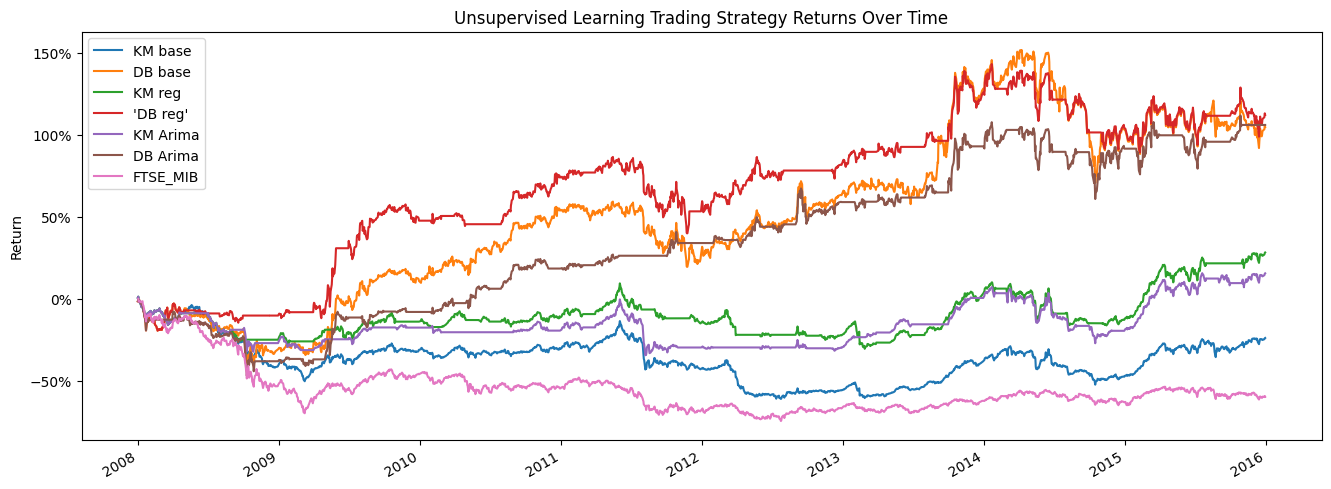

In [23]:
plot_portfolio_cumulative_return(result_training)

### Quantitative Evaluation over the training set

In [24]:
for return_strategy, name in zip(p_train_results,result_training.columns):
    print("Results obtained using", name," : ")
    print("Volatility    : ", np.round(float(calculate_volatility(return_strategy)),5))
    print("Sharpe ratio : ", np.round(float(calculate_sharpe_ratio(return_strategy)),5))

Results obtained using KM base  : 
Volatility    :  0.01252
Sharpe ratio :  -0.00433
Results obtained using DB base  : 
Volatility    :  0.01616
Sharpe ratio :  0.02996
Results obtained using KM reg  : 
Volatility    :  0.00959
Sharpe ratio :  0.01768
Results obtained using 'DB reg'  : 
Volatility    :  0.012
Sharpe ratio :  0.03692
Results obtained using KM Arima  : 
Volatility    :  0.00975
Sharpe ratio :  0.01228
Results obtained using DB Arima  : 
Volatility    :  0.01275
Sharpe ratio :  0.03437
Results obtained using FTSE_MIB  : 
Volatility    :  0.01805
Sharpe ratio :  -0.01568


In [42]:
portfolio_cumulative_return_train = np.exp(np.log1p(result_training).cumsum()) - 1

In [43]:
portfolio_cumulative_return_train.iloc[-1]

KM base    -0.237120
DB base     1.048616
KM reg      0.284115
'DB reg'    1.122644
KM Arima    0.156993
DB Arima    1.061714
FTSE_MIB   -0.595648
Name: 2015-12-30 00:00:00, dtype: float64

## Validation

In [25]:
best_rsi_data_M_km_val = data_validation.copy().dropna().groupby('date', 
                                                             group_keys=False).apply(lambda df: kmeans_best_rsi(df, 3))
chosen_stocks_km_val = list_monthly_stocks(best_rsi_data_M_km_val)

In [26]:
best_rsi_data_M_db_val =data_validation.copy().dropna().groupby('date',
                                                                group_keys = False).apply(lambda df: dbscan_best_rsi(df,3))
chosen_stocks_db_val = list_monthly_stocks(best_rsi_data_M_db_val)

In [27]:
stocks_km_val = list(np.unique([s for stocks_list in chosen_stocks_km_val.values() for s in stocks_list]))
stocks_db_val = list(np.unique([s for stocks_list in chosen_stocks_db_val.values() for s in stocks_list]))

start_date_val = data_validation.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12)
end_date_val = data_validation.index.get_level_values('date').unique()[-1]

new_df_k_means_val = yf.download(tickers = stocks_km_val,
                             start = start_date_val, 
                             end = end_date_val)

new_df_db_val = yf.download(tickers = stocks_db_val,
                        start = start_date_val, 
                        end = end_date_val)

[*********************100%%**********************]  181 of 181 completed
[*********************100%%**********************]  79 of 79 completed


In [28]:
p_val_results = []

In [29]:
p_km_val = daily_portfolio_return(chosen_stocks_km_val,
                                         new_df_k_means_val, 
                                         stop_loss = False)

p_db_val = daily_portfolio_return(chosen_stocks_db_val,
                                         new_df_db_val, 
                                         stop_loss = False)

p_val_results.append(p_km_val)
p_val_results.append(p_db_val)

In [30]:
p_km_reg_val = daily_portfolio_return(chosen_stocks_km_val,
                                      new_df_k_means_val, 
                                      off_set_days = 14, 
                                      stop_loss = True)

p_db_reg_val = daily_portfolio_return(chosen_stocks_db_val,
                                      new_df_db_val, 
                                      off_set_days = 14,
                                      stop_loss = True)

p_val_results.append(p_km_reg_val)
p_val_results.append(p_db_reg_val)

Number of times the filter has been used:  21
Number of times the filter has been used:  28


In [31]:
p_km_ARIMA_val = daily_portfolio_return(chosen_stocks_km_val,
                                        new_df_k_means_val,
                                        off_set_days = 14,
                                        stop_loss = True,
                                        mode = 'Arima')

p_db_ARIMA_val = daily_portfolio_return(chosen_stocks_db_val,
                                        new_df_db_val,
                                        off_set_days = 14,
                                        stop_loss = True,
                                        mode = 'Arima')

p_val_results.append(p_km_ARIMA_val)
p_val_results.append(p_db_ARIMA_val)

Number of times the filter has been used:  36
Number of times the filter has been used:  47


In [32]:
mib = yf.download(tickers='FTSEMIB.MI',
                  start = start_date_validation,
                  end = end_date_validation)

mib_ret = np.log(mib[['Adj Close']]).diff().dropna().rename({'Adj Close':'FTSEMIB.MI'}, axis=1)

p_val_results.append(mib_ret)


result_validation = pd.concat(p_val_results, axis=1)

result_validation.columns = ['KM base',
                         'DB base',
                         'KM reg',
                         "'DB reg'",
                         'KM Arima',
                         'DB Arima',
                         'FTSE_MIB',]

[*********************100%%**********************]  1 of 1 completed


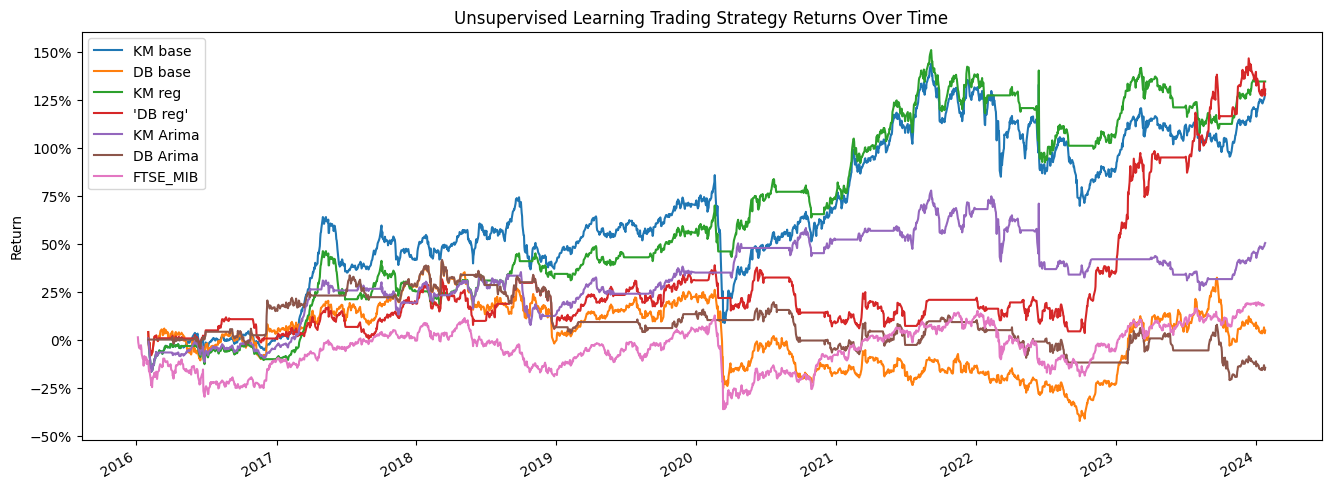

In [33]:
plot_portfolio_cumulative_return(result_validation)

In [34]:
for return_strategy, name in zip(p_val_results,result_validation.columns):
    print("Results obtained using", name," : ")
    print("Volatility    : ", float(calculate_volatility(return_strategy)))
    print("Sharpe ratio : ", float(calculate_sharpe_ratio(return_strategy)))

Results obtained using KM base  : 
Volatility    :  0.013377268238944457
Sharpe ratio :  0.03704349766198394
Results obtained using DB base  : 
Volatility    :  0.015464560250899028
Sharpe ratio :  0.00925618867783057
Results obtained using KM reg  : 
Volatility    :  0.011104194125531219
Sharpe ratio :  0.0433026641488209
Results obtained using 'DB reg'  : 
Volatility    :  0.011796964128978864
Sharpe ratio :  0.04065326647256974
Results obtained using KM Arima  : 
Volatility    :  0.010363534934224932
Sharpe ratio :  0.024531786403229883
Results obtained using DB Arima  : 
Volatility    :  0.010371596872829028
Sharpe ratio :  -0.002363403125483297
Results obtained using FTSE_MIB  : 
Volatility    :  0.014196743218935153
Sharpe ratio :  0.01291390396620676


In [38]:
portfolio_cumulative_return_val = np.exp(np.log1p(result_validation).cumsum()) - 1

In [41]:
portfolio_cumulative_return_val.iloc[-1]

KM base     1.278030
DB base     0.046818
KM reg      1.344033
'DB reg'    1.302074
KM Arima    0.502766
DB Arima   -0.147133
FTSE_MIB         NaN
Name: 2024-01-26 00:00:00, dtype: float64